# 第8週：分析PTT八卦版水庫相關文章之詞彙關係

**Author:** 林賢育N094220003 林建玄N094220004 楊雯珺 N094220006   田又仁N094220013   
**Date created:** 2021/11/  
**Last modified:** 2021/11/  
在這個Jupyter Notebook中將會以八卦版物價相關文章做為分析資料。


## 大綱
動機和分析目的

資料集描述及分析過程
- 1. 套件載入
- 2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
- 3. TF-IDF
    - 3.1 計算每篇文章的詞數
    - 3.2 合併需要的資料欄位
    - 3.3 計算tf-idf值
    - 3.4 檢視結果
    - 3.5 使用 LIWC 進行情緒分析；文章數對比物價指數
    - 3.6 文字雲
- 4. 透過結巴斷詞與N-gram幫助建立字典
    - 4.1 Bigram
    - 4.2 Trigram
- 5. 使用自建字典
- 6. 建立Ngram預測模型
- 7. Bigram視覺化
- 8. Pairwise correlation
    - 8.1 找出相關性高的詞彙
    - 8.2 畫出關係圖
- 9. 計算文章相似度

視覺化分析結果與解釋

結論

# **動機和分析目的**

由於現在物價波動頻繁，尤其疫情關係，需求量減少，反而許多物價不減反增，來弭平商家的損失，惟薪水卻一直凍漲。為此，本次報告將深入探討，物價是否會引起討論聲浪變高，正負面情緒到底哪一個比較多，物價變高是否會引起民怨，引起民怨的又有關那些字詞。



*   物價上漲是否造成大量的負面情緒？原因為何？
*   對此議題討論之情緒高峰為何？以及網友的想法？




# **資料集描述及分析過程**

## 1. 套件載入

In [ ]:
# %pip install -U networkx
# %pip install -U wordcloud
# %pip install -U scikit-learn scipy matplotlib 

載入資料

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.dates as mdates
import re
import jieba
import jieba.analyse
import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

In [ ]:
# 設定圖的字體
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

將資料顯示中文

In [ ]:
# cloab 字體設定
# !wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
# matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
# matplotlib.rc('font', family='Taipei Sans TC Beta')

## 2. 資料前處理

### 2.1 基本資料介紹
- 資料來源: 文字平台收集PTT Gossip版 2019/10/31 ~ 2021/11/31 所有文章
- 資料集： ptt_gos_commodity_articleMetaData
- 關鍵字：物價
- 資料時間：2019/10/31 ~ 2021/11/31
- 資料筆數：共 4674 篇文章

將資料匯入，設定繁體中文字體UTF-8

In [ ]:
#匯入資料
MetaData = pd.read_csv('./raw_data/ptt_gos_commodity_articleMetaData.csv', encoding='UTF-8')
cpiData = pd.read_csv('./raw_data/cpi.csv', encoding='UTF-8')

In [ ]:
#轉換日期格式
cpiData['date'] = pd.to_datetime(cpiData['date'], format="%Y/%m").dt.date
cpiData.tail(3)

,date,cpi
23,2021-09-01,105.08
24,2021-10-01,105.40
25,2021-11-01,NaN


爬蟲爬出最熱門的文章

In [ ]:
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[問卦]月薪12萬年薪144萬就足夠買下鄉民人格?,2019/09/30,17:38:39,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,oz5566,Gossiping,7,4,0,人格是三小\n\n一堆22k工作給老版當狗幹\n南部還有時薪80的早餐店\n老闆把員工當狗罵...
1,Re:[新聞]張忠謀痛心！台積電老將投靠陸廠竟做這,2019/09/30,19:15:03,https://www.ptt.cc/bbs/Gossiping/M.1569900065....,naipin2003,Gossiping,23,4,7,中國政府要是一個月給我100萬新台幣，我也馬上變五毛黨。\n\n\n為什麼？\n\n\n因為...
2,[新聞]南韓通膨率54年來首見負數出口連10月下滑,2019/10/01,04:49:37,https://www.ptt.cc/bbs/Gossiping/M.1569934541....,Cassander,Gossiping,17,6,0,1.媒體來源:udn\n2.記者署名劉忠勇、林奕榮\n3.完整新聞標題:南韓通膨率54年來首...


### 2.2 資料清理  
*   去除特殊字元與標點符號
*   日期格式化
*   去除特殊字元
*   詞頻太低的字





In [ ]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
#只留下中文字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',x))

In [ ]:
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[問卦]月薪12萬年薪144萬就足夠買下鄉民人格?,2019/09/30,17:38:39,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,oz5566,Gossiping,7,4,0,人格是三小一堆工作給老版當狗幹南部還有時薪的早餐店老闆把員工當狗罵每個人都有一個價碼信不信他...
1,Re:[新聞]張忠謀痛心！台積電老將投靠陸廠竟做這,2019/09/30,19:15:03,https://www.ptt.cc/bbs/Gossiping/M.1569900065....,naipin2003,Gossiping,23,4,7,中國政府要是一個月給我萬新台幣我也馬上變五毛黨為什麼因為台灣國的政府只會給勞工最低工資為什麼...
2,[新聞]南韓通膨率54年來首見負數出口連10月下滑,2019/10/01,04:49:37,https://www.ptt.cc/bbs/Gossiping/M.1569934541....,Cassander,Gossiping,17,6,0,劉忠勇林奕榮南韓通膨率年來首見負數出口連月下滑南韓統計局周二日公布月消費者物價指數較去年同期...


### 2.3 文章斷詞與整理

In [ ]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

#新增stop words

#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
stopWords.append("國語日報")

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [ ]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

Building prefix dict from /Users/beemo/Documents/中山/二上/社群媒體/SMA_2021F/midterm/dict/dict.txt.big ...
Loading model from cache /var/folders/pb/7gdg5h6n4y3_8g14d0151y9w0000gn/T/jieba.u88ac3af86054b668fb67670014aec343.cache
Loading model cost 0.524 seconds.
Prefix dict has been built successfully.


In [ ]:
# 將word欄位展開
data = data.explode('word')

In [ ]:
data.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,Re:[問卦]月薪12萬年薪144萬就足夠買下鄉民人格?,2019/09/30,17:38:39,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,oz5566,Gossiping,7,4,0,人格是三小一堆工作給老版當狗幹南部還有時薪的早餐店老闆把員工當狗罵每個人都有一個價碼信不信他...,人格
0,Re:[問卦]月薪12萬年薪144萬就足夠買下鄉民人格?,2019/09/30,17:38:39,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,oz5566,Gossiping,7,4,0,人格是三小一堆工作給老版當狗幹南部還有時薪的早餐店老闆把員工當狗罵每個人都有一個價碼信不信他...,一堆
0,Re:[問卦]月薪12萬年薪144萬就足夠買下鄉民人格?,2019/09/30,17:38:39,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,oz5566,Gossiping,7,4,0,人格是三小一堆工作給老版當狗幹南部還有時薪的早餐店老闆把員工當狗罵每個人都有一個價碼信不信他...,工作


In [ ]:
#計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)

In [ ]:
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,一個月,1
1,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,一堆,2
2,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,人格,1
3,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,低薪,1
4,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,來到,1
...,...,...,...
344152,https://www.ptt.cc/bbs/Gossiping/M.1635604629....,開價,1
344153,https://www.ptt.cc/bbs/Gossiping/M.1635604629....,開放,1
344154,https://www.ptt.cc/bbs/Gossiping/M.1635604629....,隔壁,3
344155,https://www.ptt.cc/bbs/Gossiping/M.1635604629....,隔天,1


## 3. TF-IDF
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
### 3.1 計算每篇文章的詞數

In [ ]:
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,20
1,https://www.ptt.cc/bbs/Gossiping/M.1569900065....,56
2,https://www.ptt.cc/bbs/Gossiping/M.1569934541....,194
3,https://www.ptt.cc/bbs/Gossiping/M.1569941443....,301
4,https://www.ptt.cc/bbs/Gossiping/M.1569941613....,381
...,...,...
4669,https://www.ptt.cc/bbs/Gossiping/M.1635595628....,231
4670,https://www.ptt.cc/bbs/Gossiping/M.1635596586....,74
4671,https://www.ptt.cc/bbs/Gossiping/M.1635596817....,20
4672,https://www.ptt.cc/bbs/Gossiping/M.1635603383....,36


### 3.2 合併需要的資料欄位
- 合併 **每個詞彙在每個文章中出現的次數** 與 **每篇文章的詞數**
- 新增各個詞彙在所有詞彙中的總數欄位

In [ ]:
water_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
water_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,一個月,1,20
1,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,一堆,2,20
2,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,人格,1,20
3,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,低薪,1,20
4,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,來到,1,20
...,...,...,...,...
344152,https://www.ptt.cc/bbs/Gossiping/M.1635604629....,開價,1,79
344153,https://www.ptt.cc/bbs/Gossiping/M.1635604629....,開放,1,79
344154,https://www.ptt.cc/bbs/Gossiping/M.1635604629....,隔壁,3,79
344155,https://www.ptt.cc/bbs/Gossiping/M.1635604629....,隔天,1,79


### 3.3 計算 tf-idf 值
- 以每篇文章爲單位，計算每個詞彙的 tf-idf 值  
    - TF (Term Frequency):某一個詞彙在某一個文件中所出現的頻率。  
        詞彙在該文件中出現次數 / 該文件中詞彙總數  
    - IDF (Inverse Document Frequent):為文件數除以某特定詞彙有被多少文件所提及的數量取log。評估詞彙在文集的獨特性  
        log( 總文件數量 / 包含該詞彙的文件數量 ) 

In [ ]:
#計算tf
water_words_tf_idf = water_words.assign(tf = water_words.iloc[:,2]/water_words.iloc[:,3])

In [ ]:
# 計算每個詞彙出現在幾篇文章中
idf_df = water_words.groupby(['word'],as_index=False).size()
water_words_tf_idf = water_words_tf_idf.merge(idf_df,on = 'word',how = 'left')

In [ ]:
#計算idf
water_words_tf_idf = water_words_tf_idf.assign(idf = water_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

water_words_tf_idf = water_words_tf_idf.drop(labels=['size'],axis=1)

In [ ]:
#計算tf*idf
water_words_tf_idf = water_words_tf_idf.assign(tf_idf = water_words_tf_idf.iloc[:,4]*water_words_tf_idf.iloc[:,5])

In [ ]:
water_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,一個月,1,20,0.05,1.264855,0.063243
1,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,一堆,2,20,0.10,0.835904,0.083590
2,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,人格,1,20,0.05,2.766599,0.138330
3,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,低薪,1,20,0.05,1.238325,0.061916
4,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,來到,1,20,0.05,1.761204,0.088060


### 3.4 tf-idf結果

In [ ]:
# 選出每篇文章，tf-idf值最大的五個詞
group = water_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))

In [ ]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                               
https://www.ptt.cc/bbs/Gossiping/M.1569894281.A... 13    當狗  0.306763
                                                   15    老版  0.183484
                                                   14    私信  0.159628
                                                   5    信不信  0.144577
                                                   2     人格  0.138330
https://www.ptt.cc/bbs/Gossiping/M.1569900065.A... 40   幫台灣  0.103269
                                                   28   只會給  0.065530
                                                   47    晶資  0.065530
                                                   51    版芯  0.065530
                                                   53    積要  0.065530
https://www.ptt.cc/bbs/Gossiping/M.1569934541.A... 92    南韓  0.122685
                                                   67    下滑  0.077128
                                                   85    出口  0.046836
                                                   159  統計局  0.041284
                                                   146  消費者  0.033003

#### 計算整個文集中較常 tf-idf 值高的字

In [ ]:
# 從每篇文章挑選出tf-idf最大的十個詞
(water_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) #排序看前十名

,word,size
12275,日本,123
6790,基本工資,116
1123,中國,109
5161,口罩,101
15659,物價,89
14381,油價,83
18201,美國,82
19355,薪資,76
14984,漲價,66
5343,台北,65


### 3.5 使用 LIWC 進行情緒分析；文章數對比物價指數

全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版分為正向情緒與負向情緒

In [ ]:
# 載入 LIWC 字典
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/liwc/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split(","),file])
        
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc

,word,sentiments
0,一無所有,negative
1,七竅生煙,negative
2,上當,negative
3,下流,negative
4,下等,negative
...,...,...
1706,魅力,positive
1707,鮮明,positive
1708,鮮美,positive
1709,鼓勵,positive


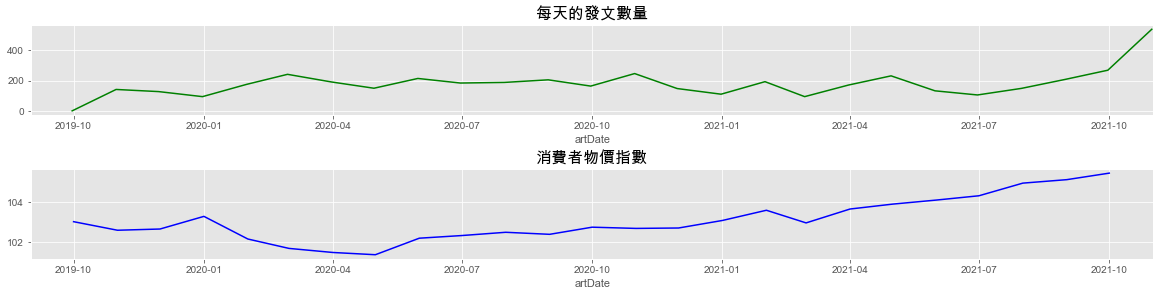

In [ ]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])
data_datecount['artDate'] = pd.to_datetime(data_datecount.index, format="%Y/%m/%d")
data_datecount = data_datecount.groupby(pd.Grouper(key='artDate', freq='1M')).sum()

plt.style.use("ggplot")     # 使用ggplot主題樣式

fig,ax = plt.subplots(2, 1, figsize=(16,4), constrained_layout=True)

ax[0].set_title('每天的發文數量', fontsize=16)
ax[0].set_xlabel('artDate', fontsize=11)

ax[1].set_title('消費者物價指數', fontsize=16)
ax[1].set_xlabel('artDate', fontsize=11)


ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


ax[0].plot(data_datecount.index, data_datecount['count'].tolist(), color='g')
ax[0].set_xlim([datetime.date(2019, 9, 1), datetime.date(2021, 11, 1)])

ax[1].plot(cpiData['date'], cpiData['cpi'].tolist(), color='b')
ax[1].set_xlim([datetime.date(2019, 9, 1), datetime.date(2021, 11, 1)])
plt.show()

由圖可以知道，當每天物價指數越高，網路聲浪就越高

In [ ]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size()

sentiment_count.head()

,artDate,sentiments,size
0,2019/09/30,negative,1
1,2019/10/01,negative,25
2,2019/10/01,positive,12
3,2019/10/02,negative,18
4,2019/10/02,positive,11


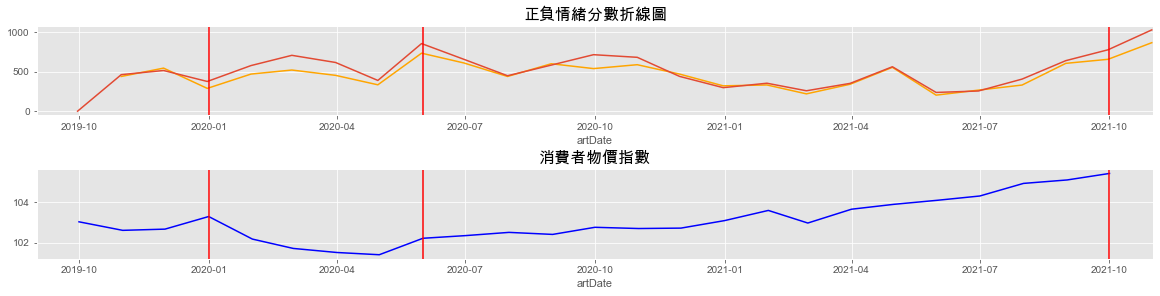

In [ ]:
pd.options.mode.chained_assignment = None

p = sentiment_count[sentiment_count['sentiments']=='positive']
p.artDate = pd.to_datetime(p.artDate)
p = p.groupby(pd.Grouper(key='artDate', freq='1M')).sum()

n = sentiment_count[sentiment_count['sentiments']=='negative']
n.artDate = pd.to_datetime(n.artDate)
n = n.groupby(pd.Grouper(key='artDate', freq='1M')).sum()

plt.style.use("ggplot")     # 使用ggplot主題樣式

fig,ax = plt.subplots(2, 1, figsize=(16,4), constrained_layout=True)

ax[0].set_title('正負情緒分數折線圖', fontsize=16)
ax[0].set_xlabel('artDate', fontsize=11)

ax[1].set_title('消費者物價指數', fontsize=16)
ax[1].set_xlabel('artDate', fontsize=11)


ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax[0].plot(p.index.tolist(), p['size'], label='positive', color="orange")
ax[0].plot(n.index.tolist(), n['size'], label='negative')
ax[0].set_xlim([datetime.date(2019, 9, 1), datetime.date(2021, 11, 1)])

ax[1].plot(cpiData['date'], cpiData['cpi'].tolist(), color='b')
ax[1].set_xlim([datetime.date(2019, 9, 1), datetime.date(2021, 11, 1)])

# 2020-01 物價相關文章較少，但物價指數高
ax[0].axvline(x=datetime.datetime.strptime('2020-01-01', "%Y-%m-%d"), color="red", ls="-")
ax[1].axvline(x=datetime.datetime.strptime('2020-01-01', "%Y-%m-%d"), color="red", ls="-")

# 2020-06 發文數在觀測期間次高
ax[0].axvline(x=datetime.datetime.strptime('2020-06-01', "%Y-%m-%d"), color="red", ls="-")
ax[1].axvline(x=datetime.datetime.strptime('2020-06-01', "%Y-%m-%d"), color="red", ls="-")

# 2021-10 發文數在觀測期間最高
ax[0].axvline(x=datetime.datetime.strptime('2021-10-01', "%Y-%m-%d"), color="red", ls="-")
ax[1].axvline(x=datetime.datetime.strptime('2021-10-01', "%Y-%m-%d"), color="red", ls="-")

plt.show()

### 3.6 根據發文量與物價指數的觀察，挑選出當月的文字雲

In [ ]:
def Wc_dict(df, dateFrom, dateTo, countB, countS):
    wc_df = (df.query('artDate > @dateFrom') # 篩選最早日期
             .query('artDate < @dateTo')# 篩選最後日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_df.sort_values('size', ascending=False)
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict

In [ ]:
#計算每天不同字的詞頻
word_count_daily = data.groupby(['artDate','word'],as_index=False).size()
word_count_daily.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count_daily = word_count_daily[word_count_daily['size']>3]  #過濾出現太少次的字

#轉換日期格式
word_count_daily['artDate'] = pd.to_datetime(word_count_daily['artDate'], format="%Y/%m/%d")
word_count_daily.head(10)

,artDate,word,size
53864,2020-02-13,口罩,281
54580,2020-02-13,政府,207
111969,2020-06-18,被告,155
111280,2020-06-18,原告,147
106744,2020-06-12,原告,144
107146,2020-06-12,捐助,135
54228,2020-02-13,工廠,124
282620,2021-09-27,女性,123
52295,2020-02-11,疫情,123
106853,2020-06-12,國語,121


In [ ]:
#### 2021-01 物價相關文章較少，但物價指數高

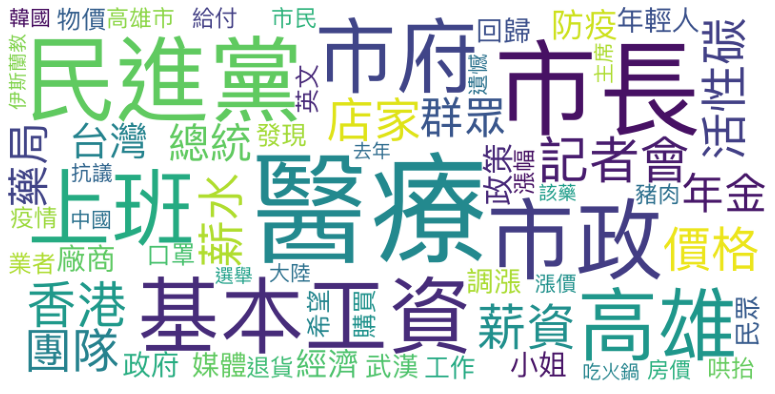

In [ ]:
dict_2020_01 = Wc_dict(word_count_daily,"2020-01-01","2020-01-31",500,10)
wordcloud = WordCloud(background_color='white',width=800, height=400,font_path="/System/Library/fonts/PingFang.ttc", colormap='viridis')
wordcloud.generate_from_frequencies(dict_2020_01)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

◆ 從文字雲可以發現:
「民進黨」、「市府」、「市長」、「基本工資」占了最大比例。有出現了「哄抬」、「遺憾」、「抗議」等負面字眼，我們推測此類「醫療」與「基本工資」調整可能是造成鄉民負面情緒的原因之一。

#### 2020-06 發文數在觀測期間次高

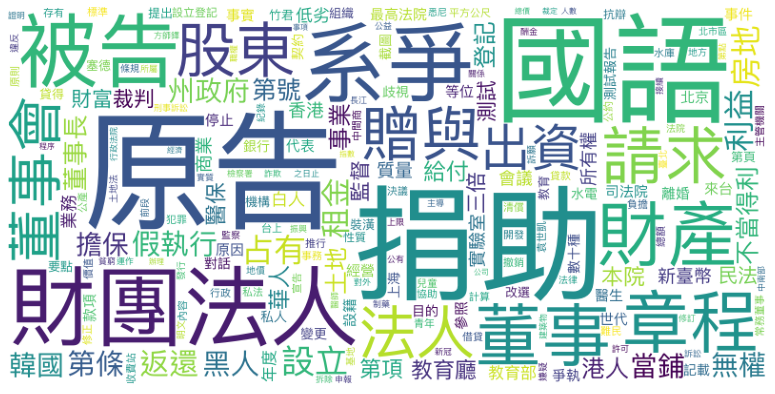

In [ ]:
dict_2020_06 = Wc_dict(word_count_daily,"2020-06-01","2020-06-30",500,0)
wordcloud = WordCloud(background_color='white',width=800, height=400,font_path="/System/Library/fonts/PingFang.ttc", colormap='viridis')
wordcloud.generate_from_frequencies(dict_2020_06)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

#### 2021-10 發文數在觀測期間最高

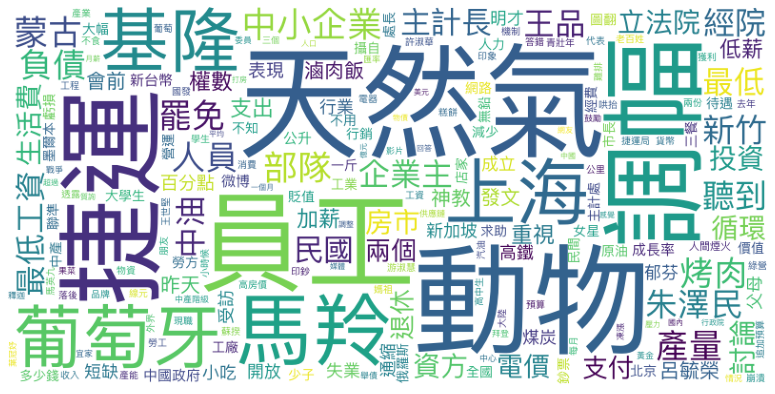

In [ ]:
dict_2021_10 = Wc_dict(word_count_daily,"2021-10-01","2021-10-31",500,0)
wordcloud = WordCloud(background_color='white',width=800, height=400,font_path="/System/Library/fonts/PingFang.ttc", colormap='viridis')
wordcloud.generate_from_frequencies(dict_2021_10)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

## 4. 透過結巴斷詞與N-gram幫助建立字典
N-gram 指文本中連續出現的n個語詞。 透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。  
N-gram範例：

### 4.1 Bigram

In [ ]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [ ]:
water_bigram = MetaData.copy()
water_bigram["word"] = water_bigram.sentence.apply(bigram_getToken)

In [ ]:
water_bigram = water_bigram.explode('word')
water_bigram.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,Re:[問卦]月薪12萬年薪144萬就足夠買下鄉民人格?,2019/09/30,17:38:39,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,oz5566,Gossiping,7,4,0,人格是三小一堆工作給老版當狗幹南部還有時薪的早餐店老闆把員工當狗罵每個人都有一個價碼信不信他...,人格 一堆
0,Re:[問卦]月薪12萬年薪144萬就足夠買下鄉民人格?,2019/09/30,17:38:39,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,oz5566,Gossiping,7,4,0,人格是三小一堆工作給老版當狗幹南部還有時薪的早餐店老闆把員工當狗罵每個人都有一個價碼信不信他...,一堆 工作
0,Re:[問卦]月薪12萬年薪144萬就足夠買下鄉民人格?,2019/09/30,17:38:39,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,oz5566,Gossiping,7,4,0,人格是三小一堆工作給老版當狗幹南部還有時薪的早餐店老闆把員工當狗罵每個人都有一個價碼信不信他...,工作 老版


#### 統計最常出現的bigram組合

In [ ]:
# 計算每個組合出現的次數
water_bigram_count = water_bigram.groupby(["word"],as_index=False).size()

In [ ]:
# 清除包含英文或數字的bigram組合
wb_filter = list(water_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
water_bigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
163789,房價 物價,259
219230,武漢 肺炎,227
83302,台灣 物價,214
243719,物價 房價,212
243159,物價 便宜,197
89779,哄抬 物價,172
22751,主計 總處,169
296702,肺炎 疫情,157
284017,經濟 成長率,155
205610,有沒有 八卦,152


### 4.2 Trigram

In [ ]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [ ]:
water_trigram = MetaData.copy()
water_trigram["word"] = water_trigram.sentence.apply(trigram_getToken)
water_trigram = water_trigram.explode('word')
water_trigram.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,Re:[問卦]月薪12萬年薪144萬就足夠買下鄉民人格?,2019/09/30,17:38:39,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,oz5566,Gossiping,7,4,0,人格是三小一堆工作給老版當狗幹南部還有時薪的早餐店老闆把員工當狗罵每個人都有一個價碼信不信他...,人格 一堆 工作
0,Re:[問卦]月薪12萬年薪144萬就足夠買下鄉民人格?,2019/09/30,17:38:39,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,oz5566,Gossiping,7,4,0,人格是三小一堆工作給老版當狗幹南部還有時薪的早餐店老闆把員工當狗罵每個人都有一個價碼信不信他...,一堆 工作 老版
0,Re:[問卦]月薪12萬年薪144萬就足夠買下鄉民人格?,2019/09/30,17:38:39,https://www.ptt.cc/bbs/Gossiping/M.1569894281....,oz5566,Gossiping,7,4,0,人格是三小一堆工作給老版當狗幹南部還有時薪的早餐店老闆把員工當狗罵每個人都有一個價碼信不信他...,工作 老版 當狗


#### 統計最常出現的trigram組合

In [ ]:
# 計算每個組合出現的次數
water_trigram_count = water_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
wb_filter = list(water_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
water_trigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
257355,武漢 肺炎 疫情,78
225510,新冠 肺炎 疫情,50
122952,基本工資 審議 委員會,49
304299,疫情 防控 工作,35
437637,非洲 豬瘟 疫情,34
108417,問卦 未滿 繁體中文,32
312068,看板 禁止 政治,32
248585,板本 萬能 問板,32
263489,水桶 嚴重者 以鬧,32
245631,未滿 繁體中文 水桶,32


從上面的 bigram 和 trigram 的結果中，我們發現"美濃 水庫","烏山頭 水庫","減壓 供水"等詞可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。  
我們將詞彙整理好存在 dict 文件夾中的 water_lexicon.txt 中。

## 5. 使用自建字典

In [ ]:
#新增水情相關自定義字典
jieba.load_userdict('./dict/water_lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [ ]:
#剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

In [ ]:
#再次計算各詞彙在各文章中出現的次數
word_count2 = data2.groupby(['artUrl','word'],as_index=False).size()
word_count2.rename(columns={'size': 'count'}, inplace=True)

In [ ]:
wb_filter = list(word_count2["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
word_count2 = word_count2[wb_filter].sort_values(by=['count'], ascending=False)
word_count2.head(10)

,artUrl,word,count
118081,https://www.ptt.cc/bbs/Gossiping/M.1591936543....,原告,144
118352,https://www.ptt.cc/bbs/Gossiping/M.1591936543....,捐助,135
312062,https://www.ptt.cc/bbs/Gossiping/M.1632754206....,女性,123
118163,https://www.ptt.cc/bbs/Gossiping/M.1591936543....,國語,121
95437,https://www.ptt.cc/bbs/Gossiping/M.1588604044....,福建,119
57602,https://www.ptt.cc/bbs/Gossiping/M.1581420777....,防控,114
57373,https://www.ptt.cc/bbs/Gossiping/M.1581420777....,疫情,114
105244,https://www.ptt.cc/bbs/Gossiping/M.1589953323....,被告,111
89465,https://www.ptt.cc/bbs/Gossiping/M.1587233645....,寄養,111
110209,https://www.ptt.cc/bbs/Gossiping/M.1590638478....,被告,106


## 6. 建立Ngram預測模型
引入Markov假設，也就是當前的這個字僅僅與前幾個有限的字相關   
$$P(w_i|w_1,...,w_{i-1})=P(w_i|w_{i-m+1},...,w_{i-1})$$  
bi-gram (m=2):
$$ P(w_i|w_{i-1})=\frac {count(w_{i-1},w_i)} {count(w_{i-1})} $$   
tri-gram (m=3):  
$$ P(w_i|w_{i-2},w_{i-1})=\frac {count(w_{i-2},w_{i-1},w_i)} {count(w_{i-2},w_{i-1})} $$   



參考網站：
- [N-gram Language Models](https://towardsdatascience.com/n-gram-language-models-af6085435eeb)
- [自然語言處理 — 使用 N-gram 實現輸入文字預測](https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-%E4%BD%BF%E7%94%A8-n-gram-%E5%AF%A6%E7%8F%BE%E8%BC%B8%E5%85%A5%E6%96%87%E5%AD%97%E9%A0%90%E6%B8%AC-10ac622aab7a)
- [自然語言處理中N-Gram模型介紹](https://zhuanlan.zhihu.com/p/32829048)

**使用我們的物價資料集**

In [ ]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [ ]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [ ]:
#Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [ ]:
text = '物價'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 房價, probability: 0.0417
next word: 便宜, probability: 0.0387
next word: 上漲, probability: 0.021
next word: 台灣, probability: 0.0181
next word: </s>, probability: 0.0146


In [ ]:
text = '薪水'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 物價, probability: 0.0664
next word: 沒漲, probability: 0.0297
next word: 台灣, probability: 0.0226
next word: 房價, probability: 0.0141
next word: 漲幅, probability: 0.0127


In [ ]:
text = '便當'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 漲價, probability: 0.024
next word: 價格, probability: 0.0216
next word: 吃不飽, probability: 0.0192
next word: 多少錢, probability: 0.0192
next word: 便當, probability: 0.0144


依據先前的分析，可以預測下一個出現的詞「物價」、「薪水」與「便當」

## 7. Bigram視覺化

In [ ]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [ ]:
water_bigram2 = MetaData.copy()
water_bigram2["word"] = water_bigram2.sentence.apply(bigram_getToken_dict)

In [ ]:
water_bigram2 = water_bigram2.explode('word')
# water_bigram2.head(3)

In [ ]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('房價', '物價'), 258),
 (('武漢', '肺炎'), 227),
 (('台灣', '物價'), 214),
 (('物價', '房價'), 212),
 (('物價', '便宜'), 197)]

In [ ]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}

In [ ]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.3 for w in  G.edges(data=True)]

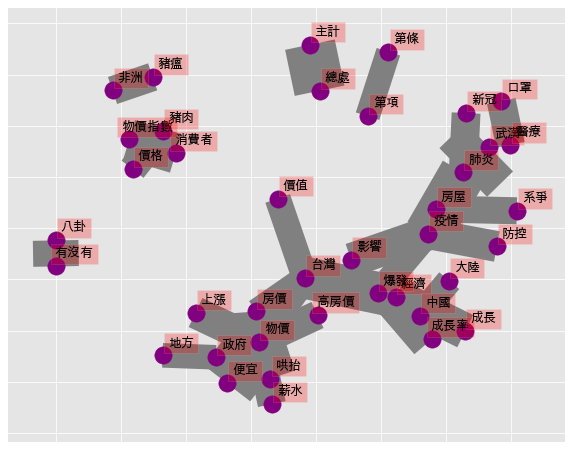

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 8. Pairwise correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  
<img src="./img/pic1.png" style="float:left;" width="50%">  
<img src="./img/pic2.png" style="float:left;" width="25%">

In [ ]:
#取常一起出現的bigram pair 前500筆
b = {k:v for k,v in bigramfdist.most_common(500)}
# b.items()

In [ ]:
#建立DataFrame
bigram_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    bigram_df = bigram_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [ ]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(word_count2[word_count2["word"]==df["word"]]["artUrl"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(word_count2[word_count2["word"]==df["word2"]]["artUrl"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(word_count2[word_count2["word"]==df["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==df["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["artUrl"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [ ]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

### 8.1 和 物價, 薪水 相關性最高的 15 個詞彙

In [ ]:
c_sum = bigram_df[(bigram_df["word"]=="物價")].sort_values(by=['cor'], ascending = False).head(15)
b_sum = bigram_df[(bigram_df["word"]=="薪水")].sort_values(by=['cor'], ascending = False).head(15)
d_sum = bigram_df[(bigram_df["word"]=="台灣")].sort_values(by=['cor'], ascending = False).head(15)

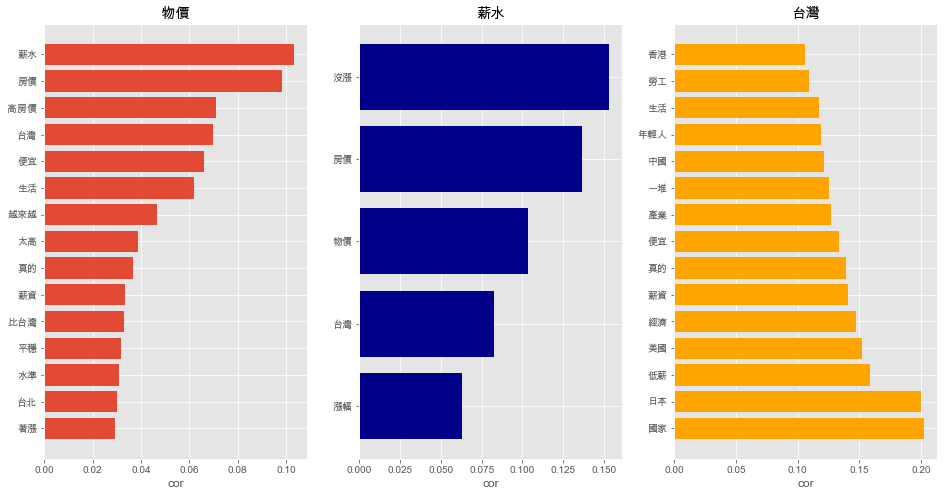

In [ ]:
c_sum = c_sum.sort_values(by=['cor'])
b_sum = b_sum.sort_values(by=['cor'])

plt.figure(figsize=(16,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(131)
plt.title('物價')
plt.xlabel('cor')
plt.barh(c_sum['word2'],c_sum['cor'])

plt.subplot(132)
plt.title('薪水')
plt.xlabel('cor')
plt.barh(b_sum['word2'],b_sum['cor'],color="darkblue")

plt.subplot(133)
plt.title('台灣')
plt.xlabel('cor')
plt.barh(d_sum['word2'],d_sum['cor'],color="orange")


plt.show()

由分析得知


*   與物價上漲有關的詞為「薪水」與「房價」最多
*   與薪水關的詞為「沒漲」與「房價」最多



### 8.2 使用詞彙關係圖畫出相關性大於0.4的組合

In [ ]:
bigram_df[bigram_df["cor"]>0.4]

,word,word2,n,cor
1,武漢,肺炎,227,0.677434
6,主計,總處,169,0.903542
7,肺炎,疫情,157,0.419611
9,有沒有,八卦,152,0.500271
11,消費者,物價指數,134,0.451281
...,...,...,...,...
438,萬片,口罩,18,0.404868
451,台商,回流,17,0.455761
471,圖翻,攝自,17,0.685332
490,債留,子孫,17,0.786120


In [ ]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [ ]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

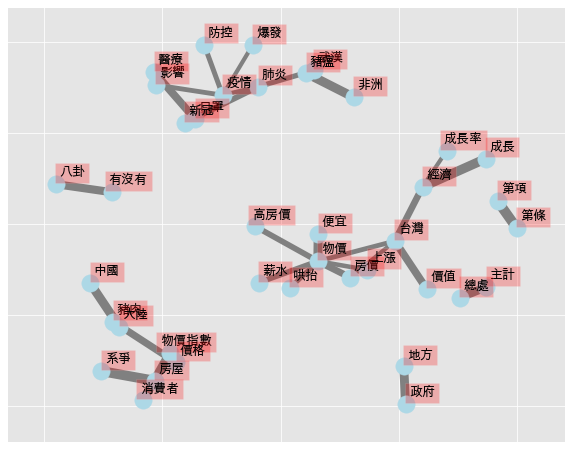

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 9. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章  
<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [ ]:
data_cos= MetaData.copy()
data_cos = data_cos.loc[:,["artTitle","artDate","artUrl","sentence"]]
# 需要改成使用空格連接斷好的詞
data_cos['word'] = data_cos.sentence.apply(getToken).map(' '.join)

In [ ]:
# data_cos.head(2)

In [ ]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_cos["word"])
vocabulary = vectorizer.get_feature_names()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df.head()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,一一,一丁點,一七,一三五,一三為,一上,一上午,一上台,一下全部,一下子,...,龍鳳,龍鳳配,龐大,龔明鑫,龜兔,龜公,龜公環,龜山,龜山島,龜毛
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
transformer = TfidfTransformer()  
print(transformer) 
#將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df.head()

TfidfTransformer()


,一一,一丁點,一七,一三五,一三為,一上,一上午,一上台,一下全部,一下子,...,龍鳳,龍鳳配,龐大,龔明鑫,龜兔,龜公,龜公環,龜山,龜山島,龜毛
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 計算 cosine_similarity
def cosine_similarity(vector):
    cos_list = []
    for i in tfidf.toarray():
        score = np.dot(vector, i)  / (norm(vector) * norm(i))
        cos_list.append(score)
    df = pd.DataFrame(cos_list, columns=["cos_similarity"])
    return df

找和第3篇文章相似的其他文章

In [ ]:
print(tfidf.toarray()[1])
cos_df = cosine_similarity(tfidf.toarray()[3])

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
# cos_df.head()
cos_df.loc[:,["cos_similarity","artTitle"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle
3,1.000000,[新聞]受豬瘟影響豬價一飛衝天 凸顯大陸內需經
3395,0.455515,[問卦]臺灣唯一能嘲笑大陸豬肉貴也被打臉了？
104,0.406904,[新聞]非洲豬瘟逼爆中國肉價9月進口豬肉年增7成
892,0.403912,[新聞]大陸豬肉價格翻倍漲供應正進一步短缺
197,0.367518,[新聞]不是真肉還比豬肉貴7倍！為何一上市就被
308,0.329663,[新聞]官媒稱炒豬團人為製造豬瘟被指是中共卸
2103,0.329659,Re:[問卦]中國的物價也不便宜薪水這麼低怎麼活阿
1776,0.321997,[新聞]大陸豬肉價飆漲85%民眾：早已吃不起！
1794,0.321196,[新聞]中國豬價又飆漲網自嘲「說你像頭豬是高估
63,0.312853,[新聞]大陸9月CPI上漲3%豬肉價格大漲近七成


# **視覺化的分析結果與解釋**


1.   每天的發文和消費者的物家指數


> 2021-04物價飆漲 創歷史新高一路狂飆 但是反映在ptt相關的文章也增加




2.   正負面的文章數和時間呈現同步的消長以每季區分可以看出2021Q2和Q3透過物質開始上揚 正負的情緒起高低的差值也開始便高中

3.   文字雲中我們用了三個時期來分析




> 2020.01 物價次高 發文數低發文關鍵字圍繞在基本工資,政府,當時因應大選完畢所以滿多文章有討論到政府和市政及政黨


> 2020.06 物價低 發文次數次高 當時背景主計總處今公布5月份消費者物價指數為101.42，上年同月相比跌1.19％，是連4個月下跌，也是2009年12月以來最大跌幅，主因油料費、燃氣及蔬菜價格下跌，加以通訊費及旅館住宿費調降所致.鄉民大部分再討論捐助財團法人,原告國語 相較第一個壁較沒有民生上的問題討論

> 2021.12 物價最高 發文次數最高 關鍵字回到探討文章中的 關鍵字漲幅員工,而第一名的天然氣其實在文章中熱烈探討對應的物價 以下擷取自網有一篇很有熱度的文章 

"台灣要重壓未來發電的天然氣半年就漲到原本的2.5倍！！！
你能想像你們半年內  電價變2.5倍
物價變原來2.5倍以上
工業產品  民生消費全在半年內基於發電上漲
都漲2.5倍是什麼狀況嗎？？"

"我敢說  要把國家未來50%以上發電
全押在這種容易價格暴漲的天然氣上的政客！！"

接著就有很多鄉民開始討論天然氣的連續暴漲後物價的相關性

4. 共線關係圖經濟 台灣 物價 有強烈的關係

5. 和物價關係的最有相關性字是:薪水 房價 高房價;和薪水關係的最有相慣性字是:沒漲,房價,物價

6. 計算兩個詞彙間的相關性 Phi相關係數 > 0.4組合中唯一可以合理解釋的是消費者和物價指數

7.  Cosine Similarity 找出相似的文章找到豬瘟對應物價(豬價)一飛衝天


















# **結論**


*   物價上漲確實造成大量的負面情緒但同時也存在正面情緒,情緒差異反差也比較大,原因為物價和房價的討論有強烈相關性,另外ptt再討論台灣裡面得物價和其他鄰近國家的比如日本相對高

*   對此議題討情緒高峰為何2021.12 呼應網友的想法在主計處反應的高物價時期情緒高峰 呼應物價的討論串數和發文數緊緊地綁再一起,在網友一同撻伐物價和房價時同時有環境中如天然氣影響當時的生活需求對應房價的高低和薪水漲幅緊密相扣的負面情緒開始對政府懷疑和探討薪資水準